In [44]:
from matplotlib import pyplot as plt
from tabulate import tabulate
import numpy as np
import cv2

In [45]:
# Steps

NNN = 256

T_STEP = int(40 / 20) + 1
I_STEP = int(NNN / 40) + 1

%run -i ./ownlib/PHT-Library3.ipynb
%run -i ./ownlib/RIW-Library3.ipynb
%run -i ./ownlib/Utility.ipynb
%run -i ./ownlib/Inverse-Geometric.ipynb

In [46]:
# Import images
ori_img = cv2.imread('./assets/lena.png') #BGR
ori_logo = cv2.imread('./assets/paperplane.png', 0)

In [47]:
def ecute(n, g, p, d):
    # Preprocess Image
    IMG_BGR = cv2.resize(ori_img, (n, n)) # Original Image
    IMG_Y = getYFromBGR(IMG_BGR) #

    # Preprocess Logo
    LOGO = cv2.resize(ori_logo, (g,g))
    LOGO = (LOGO >= 128) * 1
    
    # Scrambling Logo
    LOGO_SC = scramble(LOGO)
    
    # Transform
    MOMEN = transformPHT(IMG_Y, n, p, 'Transform Image, N={} G={} P={} D={}'.format(n, g, p, d))
    
    # Embedding
    (LOGO_POSITIONED, LOGO_FILTER, maxCapacity) = watermarkEmbed(LOGO, p)
    
    # Calculate Momen Changes
    MOMEN_EXPECTED = 2 * d * np.round(np.abs(MOMEN) / 2 / d)
    MOMEN_EXPECTED = MOMEN_EXPECTED + d / 2 * (LOGO_POSITIONED == 1)
    MOMEN_EXPECTED = MOMEN_EXPECTED - d / 2 * (LOGO_POSITIONED == 0)
    MOMEN_EXPECTED = MOMEN_EXPECTED + 2 * d * (MOMEN_EXPECTED < 0)

    MOMEN_DIFF = MOMEN_EXPECTED - np.abs(MOMEN)
    MOMEN_DIFF = MOMEN_DIFF / (np.abs(MOMEN) + 0.000000001) * MOMEN

    OMEGA = MOMEN_DIFF * LOGO_FILTER
    
    # Compensation Image
    IMG_COMPENSATION = inversePHT(OMEGA, n, p, 'Generating Compensation Image N={} G={} P={} D={}'.format(n, g, p, d))
    
    # Watermarking
    IMG_Y_WATERMARKED = IMG_Y + IMG_COMPENSATION
    IMG_WATERMARKED = putYToBGR(IMG_Y_WATERMARKED, IMG_BGR)
    
    # Calculate PSNR
    MSE = np.mean((IMG_WATERMARKED - IMG_BGR) ** 2)
    PSNR = 10 * np.log10(255 * 255 / MSE)
    
    # Return
    return (IMG_WATERMARKED, PSNR, n, g, p, d)

In [48]:
def watermarkExtractFromImage(img, ori_img, ori_logo, n, g, p, d, message=''):
    ori_img = cv2.resize(ori_img, (n, n))
    ori_logo = (cv2.resize(ori_logo, (g, g)) >= 128) * 1
    used_img = cv2.resize(img, (n, n))
    
    # Reverse Translation
    (h, w, c) = used_img.shape
    cx = (h - 1) / 2
    (tx, ty) = correctTranslate(ori_img, used_img, (cx, cx))
    used_img = attackTranslateByPixel(used_img, tx, ty)
    
    imgY = getYFromBGR(used_img)
    
    # Calculate Momen
    (n, _) = imgY.shape
    momen = transformPHT(imgY, n, p, message)
    
    # Current Binary Value & Difference
    QQ = ((np.abs(momen) - 2 * d * np.round(np.abs(momen) / 2 / d)) > 0) * 1
    
    # Crop Watermark
    extractedLogo = watermarkExtract(QQ, p, g) # MAT_Q_MODIFIED[logo_position]
    
    # Calculate Bit Error Rate    
    be = calcBE(ori_logo, extractedLogo)
    ber = be / (g * g)
    
    return (extractedLogo, ber)

In [49]:
def war(image, n):
    attackedImages = []
    
    # No Attack
    attackedImages.append((np.copy(image), 'No Attack'))
    
#     # Attack: Rotation
#     ROTATION_ANGLE = 45
#     imgRotate = attackRotation(image, ROTATION_ANGLE)
#     attackedImages.append((imgRotate, 'Rotation {}° CW'.format(ROTATION_ANGLE)))
    
#     # Attack: Scaling
#     RESIZE_FACTOR = 1.25
#     imgResize = attackResize(image, int(RESIZE_FACTOR * n))
#     attackedImages.append((imgResize, 'Scaling ' + '{:.0%}'.format(RESIZE_FACTOR)))
    
#     # Attack: Translation
#     TR_X = 0.05
#     TR_Y = -0.05
#     imgTranslate = attackTranslate(image, TR_X, TR_Y)
#     attackedImages.append((imgTranslate, 'Translation X={:.0%} Y={:.0%}'.format(TR_X, TR_Y)))
    
#     # Attack: Crop
#     CROP_PERCENTAGE = 0.05
#     imgCrop = attackCrop(image, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE, CROP_PERCENTAGE)
#     attackedImages.append((imgCrop, 'Crop {:.0%}'.format(CROP_PERCENTAGE)))
    
#     # Attack: BLUR
#     BLUR_KERNEL_SIZE = 3
#     imgBlur = attackBlur(image, BLUR_KERNEL_SIZE)
#     attackedImages.append((imgBlur, 'Blur K={}'.format(BLUR_KERNEL_SIZE)))

#     # Attack: Black & Pepper Noise
#     NOISE_PERCENTAGE = 0.05
#     imgNoise = attackRandomNoise(image, NOISE_PERCENTAGE)
#     attackedImages.append((imgNoise, 'Noise {:.0%}'.format(NOISE_PERCENTAGE)))

#     # Attack: JPG Compression
#     COMPRESSION_QUALITY = 90
#     imgJpg = attackJPG(image, COMPRESSION_QUALITY)
#     attackedImages.append((imgJpg, 'JPG Compression Q={}'.format(COMPRESSION_QUALITY)))
    
    return attackedImages

In [50]:
def proceso(watermarkData, imgAttackedList):
    TEST_DATA = []
    TEST_IMAGE = []
    TEST_LOGO = []
    TEST_HEADER = []

    # Deconstruct watermarked data
    (imgWatermarked, psnr, n, g, p, d) = watermarkData

    # Original watermark
    logo = cv2.resize(ori_logo, (g,g))
    logo = (logo >= 128) * 1

    # Initialize temporary array

    logoList = []
    imgList = []
    headerList = ['N', 'G', 'P', 'D', 'PSNR']
    dataList = [n, g, p, d, psnr]

    # Process attacked image
    for imgWithTitle in imgAttackedList[0:]:

        # Extract watermark
        (imgAttack, titleAttack) = imgWithTitle
        message = 'N={} G={} P={} D={}\n{}'.format(n, g, p, d, titleAttack)
        (logo2, ber) = watermarkExtractFromImage(imgAttack, ori_img, ori_logo, n, g, p, d, message)

        # Append column
        headerList.append(titleAttack)
        imgList.append(imgAttack)
        logoList.append(logo2)
        dataList.append(ber)

    # Append row
    TEST_HEADER = headerList
    TEST_IMAGE.append((imgList, headerList[5:]))
    TEST_LOGO.append((logoList, headerList[5:]))
    TEST_DATA.append(dataList)

    # Print result as table
    TEST_TABLE = TEST_DATA.copy()
    TEST_TABLE.insert(0, TEST_HEADER)

    return(np.array(TEST_TABLE).T, TEST_LOGO)

In [51]:
# watermarkData = ecute(NNN, 24, 48, 0.5)
watermarkData = ecute(NNN, 32, 48, 0.5)

clear_output(wait = True)
print(tabulate(
    [[watermarkData[2], watermarkData[3], watermarkData[4], watermarkData[5], watermarkData[1]]],
    headers=['N', 'G', 'P', 'D', 'PSNR'], 
    tablefmt='orgtbl'
))

|   N |   G |   P |   D |   PSNR |
|-----+-----+-----+-----+--------|
| 256 |  32 |  48 | 0.5 | 30.371 |


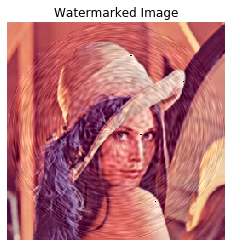

In [52]:
(imgWatermarked, psnr, n, g, p, d) = watermarkData

imgshow1(imgWatermarked, 'Watermarked Image')

| N                | 256         |
| G                |  32         |
| P                |  48         |
| D                |   0.5       |
| PSNR             |  30.371     |
| Rotation 5° CW   |   0.0146484 |
| Rotation 15° CW  |   0.0195312 |
| Rotation 25° CW  |   0.0273438 |
| Rotation 45° CW  |   0.0488281 |
| Rotation 75° CW  |   0.25293   |
| Rotation 120° CW |   0.271484  |


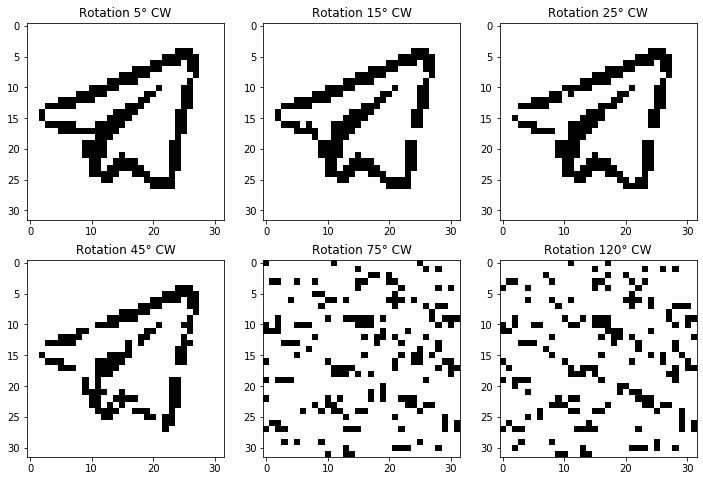

In [53]:
# Test against Rotation

TEST_R_ATTACKED = []
for rr in (5, 15, 25, 45, 75, 120):
    imgRotate = attackRotation(imgWatermarked, rr)
    TEST_R_ATTACKED.append((imgRotate, 'Rotation {}° CW'.format(rr)))
    
TEST_R_TABLE, TEST_R_LOGO = proceso(watermarkData, TEST_R_ATTACKED)

clear_output(wait = True)
print(tabulate(
    np.array(TEST_R_TABLE),
    tablefmt='orgtbl'
))

for imgAndTitle in TEST_R_LOGO:
    (image, title) = imgAndTitle
    img34 = np.array(image).reshape((2, 3, g, g))
    title34 = np.array(title).reshape((2, 3))
    imgshow(img34, title34)

| N            | 256         |
| G            |  32         |
| P            |  48         |
| D            |   0.5       |
| PSNR         |  30.371     |
| Scaling 50%  |   0.112305  |
| Scaling 70%  |   0.0703125 |
| Scaling 90%  |   0.0498047 |
| Scaling 110% |   0.0371094 |
| Scaling 130% |   0.0234375 |
| Scaling 150% |   0.0205078 |


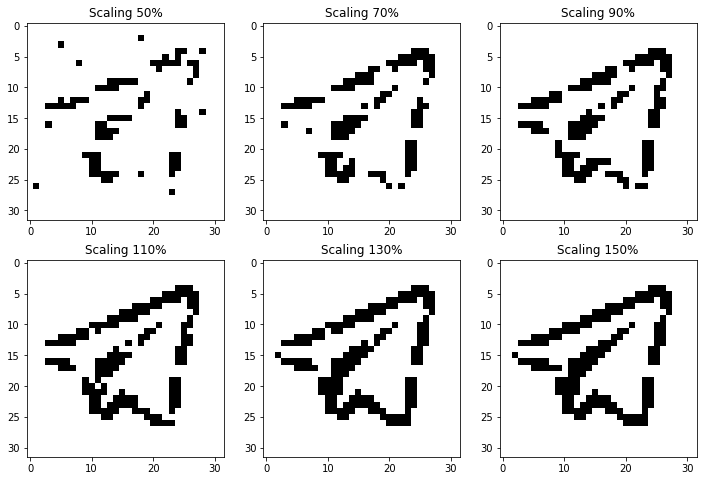

In [55]:
# Test against Scaling

TEST_S_ATTACKED = []
for ss in (0.5, 0.7, 0.9, 1.1, 1.3, 1.5):
    imgResize = attackResize(imgWatermarked, int(ss * n))
    TEST_S_ATTACKED.append((imgResize, 'Scaling ' + '{:.0%}'.format(ss)))
    
TEST_S_TABLE, TEST_S_LOGO = proceso(watermarkData, TEST_S_ATTACKED)

clear_output(wait = True)
print(tabulate(
    np.array(TEST_S_TABLE),
    tablefmt='orgtbl'
))

for imgAndTitle in TEST_S_LOGO:
    (image, title) = imgAndTitle
    imgreshape = np.array(image).reshape((2, 3, g, g))
    titlereshape = np.array(title).reshape((2, 3))
    imgshow(imgreshape, titlereshape)

| N                    | 256          |
| G                    |  32          |
| P                    |  48          |
| D                    |   0.5        |
| PSNR                 |  30.371      |
| JPG Compression Q=90 |   0          |
| JPG Compression Q=70 |   0.00390625 |
| JPG Compression Q=60 |   0.00683594 |
| JPG Compression Q=50 |   0.0126953  |
| JPG Compression Q=40 |   0.0205078  |
| JPG Compression Q=30 |   0.0292969  |
| JPG Compression Q=20 |   0.0410156  |
| JPG Compression Q=10 |   0.0673828  |


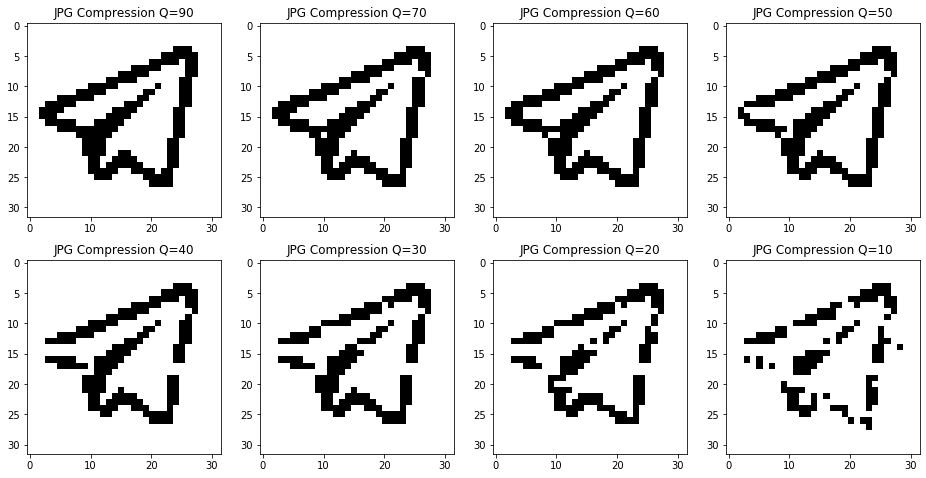

In [56]:
# Test against Compression

TEST_Q_ATTACKED = []
for qq in (90, 70, 60, 50, 40, 30, 20, 10):
    imgJpg = attackJPG(imgWatermarked, qq)
    TEST_Q_ATTACKED.append((imgJpg, 'JPG Compression Q={}'.format(qq)))
    
TEST_Q_TABLE, TEST_Q_LOGO = proceso(watermarkData, TEST_Q_ATTACKED)

clear_output(wait = True)
print(tabulate(
    np.array(TEST_Q_TABLE),
    tablefmt='orgtbl'
))

for imgAndTitle in TEST_Q_LOGO:
    (image, title) = imgAndTitle
    imgreshape = np.array(image).reshape((2, 4, g, g))
    titlereshape = np.array(title).reshape((2, 4))
    imgshow(imgreshape, titlereshape)